In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras import losses
from keras import callbacks
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
filename = '/home/mcoughlin/Seismon/Predictions/H1O1O2_CMT/earthquakes.txt' 


'''
1: earthquake gps time
2: earthquake mag
3: p gps time
4: s gps time
5: r (2 km/s)
6: r (3.5 km/s)
7: r (5 km/s)
8: predicted ground motion (m/s)
9: lower bounding time
10: upper bounding time
11: latitude
12: longitude
13: distance
14: depth (m)
15: azimuth (deg)
16: nodalPlane1_strike
17: nodalPlane1_rake
18: nodalPlane1_dip
19: momentTensor_Mrt
20: momentTensor_Mtp
21: momentTensor_Mrp
22: momentTensor_Mtt
23: momentTensor_Mrr
24: momentTensor_Mpp
25: peak ground velocity gps time
26: peak ground velocity (m/s)
27: peak ground acceleration gps time
28: peak ground acceleration (m/s^2)
29: peak ground displacement gps time
30: peak ground displacement (m)
31: Lockloss time
32: Detector Status
'''

data = pd.read_csv(filename,delimiter=' ',header=None)
#data.to_csv('H1O1O2_CMT_GPR.csv')


# Print Data
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(data[[13,25]])


In [3]:
# Remove zeros & negative entries
#data = data.loc[~(data[13].isin([0]))]
data = data.loc[~(data[13]<=0)]

In [4]:
# shuffle data
data = data.reindex(np.random.permutation(data.index))

In [5]:
# Take log 
data[[1,12, 13,25]]  = np.log10(data[[1,12, 13,25]])
Rf_Amp_thresh = -8; 
index = data[25] > Rf_Amp_thresh

data = data[:][index]



In [6]:
# Select features
FeatSet_index = [1,10,7,11,12,13,14,15,16,17,18,19,20,21,22,23]
#FeatSet_index = [2,3,24,26,28,30] #  these paramaters makes no sense
#FeatSet_index = [18,19,20,21,22,23] #  these lower set has just the moment tensor parameters
#FeatSet_index = [1,7,10,11,12,13,14,15,16,17] #  these lower set paramaters makes  sense
#FeatSet_index = [1,12,13] #  Just Mag, Dist, Depth


Target_index = [25]


# Artificially increase samples
data_temp = data
copy_num = 5
noise_level = 1e-1



Rfamp_orig = data_temp[Target_index];
data_orig =  data_temp   

In [7]:
def boost_samples(x_samples,y_samples,copy_num=3,noise_level=1e-2):
    # Artificially increase samples
    data_x_temp = x_samples
    data_y_temp = y_samples

    for i in range(copy_num):
        data_x_temp = np.vstack((data_x_temp,data_x_temp))
        data_y_temp = np.vstack((data_y_temp,data_y_temp))


    data_x_orig =  data_x_temp   
    data_y_orig =  data_y_temp   


    x1 = data_x_temp
    x2 = np.random.randn(*data_x_temp.shape)*noise_level
    x_samples_boosted = x1 + np.multiply(x1,x2)
    
    y1 = data_y_temp
    y2 = np.random.randn(*data_y_temp.shape)*noise_level
    y_samples_boosted = y1 + np.multiply(y1,y2)   
    
    # Shuffle samples
    #IDX = np.random.permutation(y_samples_boosted.index)
    IDX = np.random.permutation(np.arange(0,len(y_samples_boosted)))
    x_samples_boosted = x_samples_boosted[IDX,:]
    y_samples_boosted = y_samples_boosted[IDX,:]

    
    return x_samples_boosted, y_samples_boosted




def boost_x_samples(x_samples,copy_num=3,noise_level=1e-2):
    # Artificially increase samples
    data_temp = x_samples
    #copy_num = 2
    #noise_level = 1e-2

    for i in range(copy_num):
        data_temp = np.vstack((data_temp,data_temp))


    data_orig =  data_temp   

    x1 = data_temp
    x2 = np.random.randn(*data_temp.shape)*noise_level
    x_samples_boosted = x1 + np.multiply(x1,x2)
    return x_samples_boosted, data_orig



def boost_y_samples(y_samples,copy_num=3,noise_level=1e-2):
    # Artificially increase samples
    data_temp = y_samples
    #copy_num = 2
    #noise_level = 1e-2

    for i in range(copy_num):
        data_temp = np.vstack((data_temp,data_temp))


    data_orig =  data_temp   

    y1 = data_temp
    y2 = np.random.randn(len(data_temp))*noise_level
    y3 = np.expand_dims(y2,axis=1)
    y_samples_boosted = y1 + np.multiply(y1,y3)
    return y_samples_boosted, data_orig

In [8]:
data = data_temp

data_unscaled = data
X_us = np.asarray(data[FeatSet_index])
Y_us = np.asarray(data[Target_index])
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(X_us, Y_us, test_size=0.4,random_state=42)
x_train_us, x_val_us, y_train_us, y_val_us = train_test_split(x_train_us, y_train_us, test_size=0.4,random_state=42)

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

X = np.asarray(data[FeatSet_index])
Y = np.asarray(data[Target_index])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3,random_state=42)




In [9]:
'''
# boost Samples
x_train = boost_x_samples(x_train,copy_num,noise_level); x_train = x_train[0];
x_val   = boost_x_samples(x_val,copy_num,noise_level);   x_val   = x_val[0];
x_test  = boost_x_samples(x_test,copy_num,noise_level);  x_test  = x_test[0];

y_train = boost_y_samples(y_train,copy_num,noise_level); y_train = y_train[0];
y_val   = boost_y_samples(y_val,copy_num,noise_level);   y_val   = y_val[0];
y_test  = boost_y_samples(y_test,copy_num,noise_level);  y_test  = y_test[0];
'''

# boost_samples + shuffle them
x_train,y_train = boost_samples(x_train,y_train,copy_num,noise_level); 
x_test,y_test = boost_samples(x_test,y_test,copy_num,noise_level); 

In [10]:
#############################################
# Construct the neural network and train it #
#############################################

inp_layer = x_train.shape[1]
dense_layers = 8
dense_activation = 'relu'
optimizer = 'adam'
loss = 'mse'
#batch_size = 32 #100000
Nepoch = 20
verbose = 1
Nbatch = 2000#1000 #32 batch_size

# define the network topology  -- -- -- - - -  -  -   -   -    -  
model = Sequential()
model.add(Dense(inp_layer, input_shape=(inp_layer,), activation = 'linear'))

# this layer increases trainging time but seems to not increase performance
model.add(Dense(inp_layer, activation = 'relu'))
#model.add(Dense(Nang+Nspot, activation = 'elu'))  # try one more fully connected 

g = range( dense_layers ) # add layers; decrease size of each by half 
g1 = range( dense_layers )
g.reverse()  

#for k in g[0:-3]:
#    model.add(Dense(2**k, activation = dense_activation))  
#    model.add(Activation("linear"))



#model.add(Dense(16384,activation='relu')) 
#model.add(Activation("linear"))
#model.add(Dense(8192,activation='relu')) 
#model.add(Activation("linear"))
model.add(Dense(4096,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(2048,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(1024,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(512,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(256,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(128,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(64,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(32,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(16,activation='relu'))     
model.add(Activation("linear"))
model.add(Dense(8,activation='relu'))   
model.add(Activation("linear"))



model.add(Activation("linear"))
model.add(Dense(1,    activation = 'linear'))
model.compile(optimizer=optimizer, loss=loss)                                 
#model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss=loss) 


In [11]:
# Find the right number of epochs

W = model.get_weights()
val_loss_list = []
np.random.seed(1337)

for ep in range(1, Nepoch):
    print('{} of {}'.format(ep,Nepoch))
    model.fit(x_train, y_train,
                   validation_data = (x_val,y_val),
                   batch_size      = Nbatch,
                   epochs          = 1,
                   verbose         = verbose)   
    
    val_loss_list.append(model.evaluate(x_test,
                                    y_test, verbose=0,
                                    batch_size=Nbatch))
    
    
best_epoch = np.array(val_loss_list).argmin()

# reset model
model.reset_states()
model.set_weights(W)
np.random.seed(1337)    

1 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 3s - loss: 0.0457 - val_loss: 0.0390
2 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 2s - loss: 0.0251 - val_loss: 0.0252
3 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 3s - loss: 0.0204 - val_loss: 0.0210
4 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 3s - loss: 0.0181 - val_loss: 0.0188
5 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 2s - loss: 0.0160 - val_loss: 0.0160
6 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [==============================] - 2s - loss: 0.0143 - val_loss: 0.0153
7 of 20
Train on 17152 samples, validate on 231 samples
Epoch 1/1
17152/17152 [=====================

In [12]:
# Train with the right number of epochs
model.fit(x_train, y_train,
                   validation_data = (x_val,y_val),
                   batch_size      = Nbatch,
                   epochs          = best_epoch+1,
                   verbose         = verbose)  

Train on 17152 samples, validate on 231 samples
Epoch 1/12
17152/17152 [==============================] - 2s - loss: 0.0482 - val_loss: 0.0318
Epoch 2/12
17152/17152 [==============================] - 2s - loss: 0.0299 - val_loss: 0.0258
Epoch 3/12
17152/17152 [==============================] - 2s - loss: 0.0197 - val_loss: 0.0205
Epoch 4/12
17152/17152 [==============================] - 2s - loss: 0.0168 - val_loss: 0.0173
Epoch 5/12
17152/17152 [==============================] - 2s - loss: 0.0144 - val_loss: 0.0157
Epoch 6/12
17152/17152 [==============================] - 2s - loss: 0.0132 - val_loss: 0.0155
Epoch 7/12
17152/17152 [==============================] - 2s - loss: 0.0123 - val_loss: 0.0149
Epoch 8/12
17152/17152 [==============================] - 2s - loss: 0.0115 - val_loss: 0.0148
Epoch 9/12
17152/17152 [==============================] - 2s - loss: 0.0110 - val_loss: 0.0147
Epoch 10/12
17152/17152 [==============================] - 2s - loss: 0.0105 - val_loss: 0.0158
E

In [14]:
y_pred = model.predict(x_test)

Percentage captured within a factor of 3 = 91.38


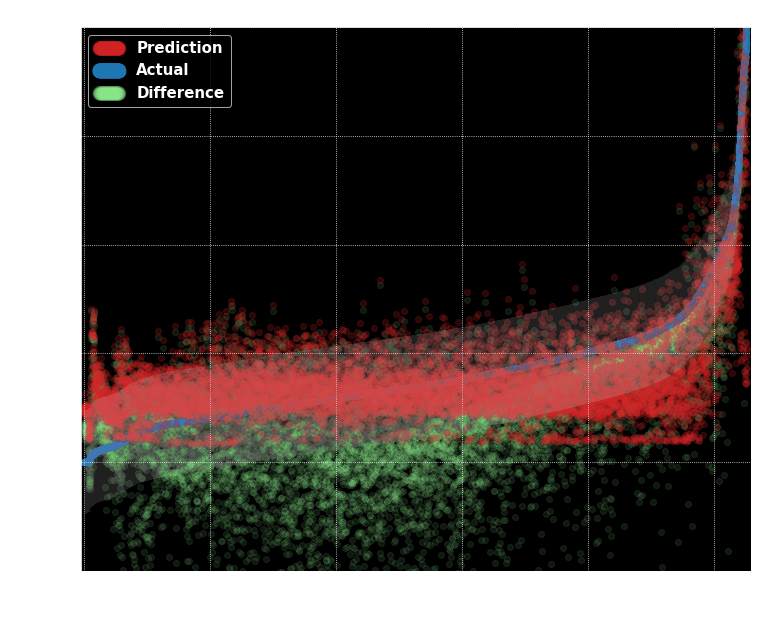

In [15]:
# Rescale back to original 
#y_test = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
#y_pred = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 3
IDX = y_pred/(y_test+np.finfo(float).eps) >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))

rescale_id = 1

if rescale_id==0 :
    # sort results in Ascending order
    y_test_sort = np.sort(y_test,axis=0)
    y_pred_sort = y_pred[np.argsort(y_test,axis=0)]
elif rescale_id == 1:
    data_origScale= min_max_scaler.inverse_transform(data)
    data_origScale = pd.DataFrame(data_origScale)

    # Rescale back to original 
    y_test_rescaled = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
    y_pred_rescaled = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
    # sort results in Ascending order
    y_test_sort = np.sort(y_test_rescaled,axis=0)
    y_pred_sort = y_pred_rescaled[np.argsort(y_test_rescaled,axis=0)]

    y_test_sort = 10**(y_test_sort)
    y_pred_sort = 10**(y_pred_sort)





Diff = abs(y_pred_sort - np.expand_dims(y_test_sort,axis=1))

# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


font = {'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(12,10))
fig1 = plt.gcf()

plt.style.use('dark_background')
#plt.style.use('ggplot')

diff_plt = plt.scatter(idx,Diff,color='lightgreen',alpha=0.1)


errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.01 ,color='lightgrey')
actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.9)


idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='#d62728',alpha=0.2)      

#actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.9)


plt.yscale('log')
plt.grid()
plt.ylim([1e-8, 1e-3])
#plt.ylim([0, 1])
#plt.ylabel('Rf Amplitude (m/s) \n (Normalized to 1)',fontsize=25)
plt.ylabel('Rf Amplitude (m/s) ',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
legend_plt = plt.legend([pred_plt,actual_plt, diff_plt],['Prediction', 'Actual', 'Difference'],loc=2,markerscale=2., scatterpoints=100)


plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle=':')

#plt.savefig('DNN_Rfamp_everything_except_moment_tensor_params_3.png',bbox_inches='tight')
#plt.savefig('DNN_Rfamp_everything_Mag_dist_depth_.png',bbox_inches='tight')
#plt.savefig('DNN_Rfamp_correct_noise_1e-2_run_iter_3000_9_layers_adaptOptimizer.png',bbox_inches='tight')


# Save Model
save_results = 0
output_filename = 'H1O1O2_CMT_copy' 


if save_results:
    
    # Create directory
    result_folder_name = './Saved_Models/Model_{}'.format(output_filename)
    os.makedirs(result_folder_name)
    # Save Figure 
    fig1.savefig('./Saved_Models/Model_{}/DNN_Rfamp_results.png'.format(output_filename),bbox_inches='tight')
    
    # Save Model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./Saved_Models/Model_{}/model.json".format(output_filename), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./Saved_Models/Model_{}/model.h5".format(output_filename))
    
    # Save network plot
    plot_model(model, to_file="./Saved_Models/Model_{}/model.png".format(output_filename))
    
    print("Saved model to disk")


In [ ]:
# Load Saved Model

output_filename = 'H1O1O2_CMT_copy' 
result_folder_name = './Saved_Models/Model_{}'.format(output_filename)
 
    
# load json and create model
json_file = open('./Saved_Models/Model_{}/model.json'.format(output_filename), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./Saved_Models/Model_{}/model.h5'.format(output_filename)  )
print("Loaded model from disk")
